In [ ]:
# Dataset             - Created by Taking all values in desired altitude range
# Data Points         - 30,17,508 
# Objective Variable  - Column Density of O3
# Model               - Simple Artificial Neural Network With AutoEncoder (Bottleneck = 6)

#**Importing Modules**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
#from sklearn.metrics import mean_absolute_percentage_error

import keras
import tensorflow as tf
from keras.layers import Dropout
from keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import BatchNormalization

#**Get files from drive** 

In [43]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [44]:
# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [45]:
# Getting Data File Nov 2003
d1 = drive.CreateFile({'id':"1r6WVCmX-bC-OMfuKYiO0zinVMqnqefhJ"})
d1.GetContentFile('Nov 2003.csv')

In [46]:
# Getting Data File of Nov 2004
d2 = drive.CreateFile({'id':"1BEaJkaW9pwbhflTbrxMmmxpLAPryJi0j"})
d2.GetContentFile('Nov 2004.csv')

In [47]:
# Getting Data File of OCT 2003
d3 = drive.CreateFile({'id':"14qrxMXnZWjVdLIwipUR_-EHRZxccKsrH"})
d3.GetContentFile('Oct 2003.csv')

In [ ]:
# Getting AutoEncoder File
d4 = drive.CreateFile({'id':"1CztMAvc-HYGwxV_DjCMkv0zI_NhtfFJS"})   
d4.GetContentFile('AutoEncoder_3.h5')

# **Data Pre-processing**

In [2]:
# Reading Files and creating data frames
f1=pd.read_csv("Nov 2003.csv")
df1=pd.DataFrame(f1)
df1

,Unnamed: 0,Date,event,solAp,solKp,solf10p7Daily,time,tpaltitude,tplatitude,tplongitude,tpSolarZen,ktemp,density,O3_96,O3_127,ae_index,dst_index,sym_h,O3_density,col_den
0,0,1,1,26.0,5.0,210.4,1320342,109.312874,11.928361,27.051359,144.264923,289.247742,2.024306e+12,8.934129e-07,--,607,-69,-74,1.808541e+06,1.921766e+10
1,1,1,1,26.0,5.0,210.4,1320210,108.209297,11.926141,27.026283,144.289459,281.309357,2.344630e+12,7.709245e-07,--,607,-69,-74,1.807533e+06,1.921766e+10
2,2,1,1,26.0,5.0,210.4,1320075,107.104729,11.923806,27.001190,144.314011,272.173126,2.741623e+12,7.041723e-07,--,607,-69,-74,1.930575e+06,1.921766e+10
3,3,1,1,26.0,5.0,210.4,1319941,105.998711,11.921523,26.976105,144.338547,263.150696,3.223496e+12,7.390482e-07,--,609,-69,-73,2.382319e+06,1.921766e+10
4,4,1,1,26.0,5.0,210.4,1319805,104.891106,11.919088,26.950996,144.363098,247.562057,3.922112e+12,7.693852e-07,--,609,-69,-73,3.017615e+06,1.921766e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2869668,2869675,30,98,12.0,3.0,152.8,89212092,75.111053,-1.790957,335.059235,154.397354,194.799866,8.174919e+14,8.063189e-07,--,347,-26,-33,6.591591e+08,1.226737e+10
2869669,2869676,30,98,12.0,3.0,152.8,89212243,73.973129,-1.789488,335.084076,154.408600,201.850632,9.546477e+14,8.691362e-07,--,347,-26,-33,8.297189e+08,1.226737e+10
2869670,2869677,30,98,12.0,3.0,152.8,89212395,72.834251,-1.788010,335.108948,154.419815,206.139069,1.125344e+15,9.823987e-07,--,347,-26,-33,1.105536e+09,1.226737e+10
2869671,2869678,30,98,12.0,3.0,152.8,89212521,71.694588,-1.787928,335.133484,154.429581,207.810104,1.340520e+15,1.248143e-06,--,347,-26,-33,1.673162e+09,1.226737e+10


In [3]:
# Reading Files and creating data frames
f2=pd.read_csv("Nov 2004.csv")
df2=pd.DataFrame(f2)
df2

,Unnamed: 0,Date,event,solAp,solKp,solf10p7Daily,time,tpaltitude,tplatitude,tplongitude,tpSolarZen,ktemp,density,O3_96,O3_127,ae_index,dst_index,sym_h,O3_density,col_den
0,0,1,1,12,2.7,139.2,3078387,109.423233,14.263371,19.487509,144.744781,276.894592,2.299960e+12,1.630000e-07,--,310,-19,-9,3.748935e+05,1.953871e+10
1,1,1,1,12,2.7,139.2,3078253,108.320251,14.260718,19.462215,144.769547,281.274963,2.555530e+12,1.630000e-07,--,310,-19,-9,4.165514e+05,1.953871e+10
2,2,1,1,12,2.7,139.2,3078119,107.216278,14.258057,19.436920,144.794327,279.596130,2.901220e+12,1.630000e-07,--,310,-19,-9,4.728989e+05,1.953871e+10
3,3,1,1,12,2.7,139.2,3077987,106.111176,14.255451,19.411634,144.819092,275.584045,3.328930e+12,1.630000e-07,--,310,-19,-9,5.426156e+05,1.953871e+10
4,4,1,1,12,2.7,139.2,3077851,105.004166,14.252700,19.386330,144.843872,275.164887,3.777170e+12,1.630000e-07,--,310,-19,-9,6.156787e+05,1.953871e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3017503,3017503,30,96,17,4.0,111.4,90231670,75.405930,-3.691292,329.487701,152.170960,211.435822,6.621610e+14,2.920000e-07,--,113,-5,-6,1.933510e+08,8.241677e+09
3017504,3017504,30,96,17,4.0,111.4,90231830,74.268173,-3.689023,329.512665,152.183365,214.712189,7.787660e+14,3.990000e-07,--,113,-5,-6,3.107276e+08,8.241677e+09
3017505,3017505,30,96,17,4.0,111.4,90231976,73.129532,-3.687521,329.537445,152.194946,213.038940,9.364770e+14,6.240000e-07,--,113,-5,-6,5.843616e+08,8.241677e+09
3017506,3017506,30,96,17,4.0,111.4,90232062,71.989670,-3.689300,329.561585,152.203140,204.414856,1.170340e+15,1.010000e-06,--,113,-5,-6,1.182043e+09,8.241677e+09


In [4]:
# Reading Files and creating data frames
f3=pd.read_csv("Oct 2003.csv")
df3=pd.DataFrame(f3)
df3

,Unnamed: 0,Date,event,solAp,solKp,solf10p7Daily,time,tpaltitude,tplatitude,tplongitude,tpSolarZen,ktemp,density,O3_96,O3_127,ae_index,dst_index,sym_h,O3_density,col_den
0,0,26,1,10.0,2.3,243.4,998145,109.473373,12.064891,46.187244,126.984222,276.386414,1.723913e+12,1.481294e-06,--,56,-31,-30,2.553622e+06,1.516348e+10
1,1,26,1,10.0,2.3,243.4,998012,108.369583,12.062634,46.162155,127.008896,259.460693,2.083176e+12,1.481294e-06,--,56,-31,-30,3.085796e+06,1.516348e+10
2,2,26,1,10.0,2.3,243.4,997876,107.263870,12.060227,46.137043,127.033592,233.853317,2.654311e+12,1.414265e-06,--,56,-31,-30,3.753898e+06,1.516348e+10
3,3,26,1,10.0,2.3,243.4,997743,106.157074,12.057986,46.111958,127.058266,207.674591,3.493698e+12,9.907167e-07,--,56,-31,-30,3.461265e+06,1.516348e+10
4,4,26,1,10.0,2.3,243.4,997607,105.049255,12.055567,46.086845,127.082954,187.036041,4.628376e+12,1.223286e-06,--,56,-31,-30,5.661828e+06,1.516348e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601267,601295,31,98,116.0,4.3,248.9,87674469,74.702950,9.541140,25.907038,145.163940,207.508942,7.681364e+14,7.164987e-07,--,609,-69,-73,5.503687e+08,1.780777e+10
601268,601296,31,98,116.0,4.3,248.9,87674600,73.563889,9.553928,25.884565,145.187637,206.174927,9.287091e+14,1.033010e-06,--,609,-69,-73,9.593660e+08,1.780777e+10
601269,601297,31,98,116.0,4.3,248.9,87674738,72.423851,9.567107,25.862158,145.211319,209.336380,1.098005e+15,1.149698e-06,--,609,-69,-73,1.262374e+09,1.780777e+10
601270,601298,31,98,116.0,4.3,248.9,87674867,71.282799,9.579803,25.839666,145.235016,211.722443,1.299769e+15,1.169214e-06,--,609,-69,-73,1.519708e+09,1.780777e+10


In [5]:
# Merging Nov 2003 & Nov 2004 datasets
df =  pd.concat([df1,df2])
df

,Unnamed: 0,Date,event,solAp,solKp,solf10p7Daily,time,tpaltitude,tplatitude,tplongitude,tpSolarZen,ktemp,density,O3_96,O3_127,ae_index,dst_index,sym_h,O3_density,col_den
0,0,1,1,26.0,5.0,210.4,1320342,109.312874,11.928361,27.051359,144.264923,289.247742,2.024306e+12,8.934129e-07,--,607,-69,-74,1.808541e+06,1.921766e+10
1,1,1,1,26.0,5.0,210.4,1320210,108.209297,11.926141,27.026283,144.289459,281.309357,2.344630e+12,7.709245e-07,--,607,-69,-74,1.807533e+06,1.921766e+10
2,2,1,1,26.0,5.0,210.4,1320075,107.104729,11.923806,27.001190,144.314011,272.173126,2.741623e+12,7.041723e-07,--,607,-69,-74,1.930575e+06,1.921766e+10
3,3,1,1,26.0,5.0,210.4,1319941,105.998711,11.921523,26.976105,144.338547,263.150696,3.223496e+12,7.390482e-07,--,609,-69,-73,2.382319e+06,1.921766e+10
4,4,1,1,26.0,5.0,210.4,1319805,104.891106,11.919088,26.950996,144.363098,247.562057,3.922112e+12,7.693852e-07,--,609,-69,-73,3.017615e+06,1.921766e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3017503,3017503,30,96,17.0,4.0,111.4,90231670,75.405930,-3.691292,329.487701,152.170960,211.435822,6.621610e+14,2.920000e-07,--,113,-5,-6,1.933510e+08,8.241677e+09
3017504,3017504,30,96,17.0,4.0,111.4,90231830,74.268173,-3.689023,329.512665,152.183365,214.712189,7.787660e+14,3.990000e-07,--,113,-5,-6,3.107276e+08,8.241677e+09
3017505,3017505,30,96,17.0,4.0,111.4,90231976,73.129532,-3.687521,329.537445,152.194946,213.038940,9.364770e+14,6.240000e-07,--,113,-5,-6,5.843616e+08,8.241677e+09
3017506,3017506,30,96,17.0,4.0,111.4,90232062,71.989670,-3.689300,329.561585,152.203140,204.414856,1.170340e+15,1.010000e-06,--,113,-5,-6,1.182043e+09,8.241677e+09


In [6]:
x_col=["Date","event","solAp","solKp","solf10p7Daily","time","tpaltitude","tplatitude","tplongitude","tpSolarZen","ktemp","ae_index","dst_index","sym_h"]  # "sym_h" , "solKp"
y_col=["O3_density"]

In [7]:
x=pd.DataFrame(columns=x_col)
y=pd.DataFrame(columns=y_col)
for i in x_col:
  x[i]=df[i]

for i in y_col:
  y[i]=df[i]

x

,Date,event,solAp,solKp,solf10p7Daily,time,tpaltitude,tplatitude,tplongitude,tpSolarZen,ktemp,ae_index,dst_index,sym_h
0,1,1,26.0,5.0,210.4,1320342,109.312874,11.928361,27.051359,144.264923,289.247742,607,-69,-74
1,1,1,26.0,5.0,210.4,1320210,108.209297,11.926141,27.026283,144.289459,281.309357,607,-69,-74
2,1,1,26.0,5.0,210.4,1320075,107.104729,11.923806,27.001190,144.314011,272.173126,607,-69,-74
3,1,1,26.0,5.0,210.4,1319941,105.998711,11.921523,26.976105,144.338547,263.150696,609,-69,-73
4,1,1,26.0,5.0,210.4,1319805,104.891106,11.919088,26.950996,144.363098,247.562057,609,-69,-73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3017503,30,96,17.0,4.0,111.4,90231670,75.405930,-3.691292,329.487701,152.170960,211.435822,113,-5,-6
3017504,30,96,17.0,4.0,111.4,90231830,74.268173,-3.689023,329.512665,152.183365,214.712189,113,-5,-6
3017505,30,96,17.0,4.0,111.4,90231976,73.129532,-3.687521,329.537445,152.194946,213.038940,113,-5,-6
3017506,30,96,17.0,4.0,111.4,90232062,71.989670,-3.689300,329.561585,152.203140,204.414856,113,-5,-6


In [8]:
y

,O3_density
0,1.808541e+06
1,1.807533e+06
2,1.930575e+06
3,2.382319e+06
4,3.017615e+06
...,...
3017503,1.933510e+08
3017504,3.107276e+08
3017505,5.843616e+08
3017506,1.182043e+09


In [ ]:
# Train Test Split
train_ratio=0.9
r=int(train_ratio*len(y))
x_train=x.iloc[:r,:]
x_test=x.iloc[r:,:]
y_train=y.iloc[:r,:]
y_test=y.iloc[r:,:]
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(2582712, 14)
(286968, 14)
(2582712, 1)
(286968, 1)


In [9]:
# Random Train-Test Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.05, random_state = 0)

In [10]:
# Data Scaling
'''# Standard Scaling
sc_x = StandardScaler()
sc_y = StandardScaler()'''

# Min-Max Scaling
sc_x = MinMaxScaler()
sc_y =  MinMaxScaler()

x_train = sc_x.fit_transform(x_train)
x_test = sc_x.transform(x_test)

y_train = sc_y.fit_transform(y_train)
y_test = sc_y.transform(y_test)

In [ ]:
# Convert the input datapoints to encoded using the Encoder part of AUTO-ENCODER

# load the model from file
autoencoder = load_model('AutoEncoder_3.h5')

# encode the train & test data
x_train_encoded = autoencoder.predict(x_train)
x_test_encoded = autoencoder.predict(x_test)

In [ ]:
print("x_train_encoded:\n",x_train_encoded)
print("\nx_test_encoded:\n",x_test_encoded)

In [11]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)
#print(x_train_encoded.shape)
#print(x_test_encoded.shape)

(5592821, 14)
(294360, 14)
(5592821, 1)
(294360, 1)


#**Model Building and Training**

In [13]:
# parameters
dfr=0.1    # Droput fracton
neu_in=x_train.shape[1]     # Input layers
neu_out=1  # Output layers
hl=8       # Hidden layers
neu=32     # No. of Neurons
bsz=64     # Batch Size
epc=20     # Epochs 
lss="mse"  # Loss function
#  Evaluation Matrix
mtx= [tf.keras.metrics.MeanSquaredError(),tf.keras.metrics.MeanAbsoluteError(),tf.keras.metrics.RootMeanSquaredError(),tf.keras.metrics.MeanAbsolutePercentageError()]
vld_splt=0.11

In [14]:
model=Sequential()

model.add(Dense(neu, input_dim = neu_in))    # Adding the input layer and the first hidden layer
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(dfr))

for i in range(hl):                                            # Adding the inner hidden layers
  model.add(Dense(neu))
  model.add(BatchNormalization())
  model.add(LeakyReLU())
  model.add(Dropout(dfr))

model.add(Dense(neu_out, activation = 'sigmoid'))                   # Adding the output layer

In [15]:
# Compiling the model   
model.compile(optimizer = 'adam', loss = lss, metrics = mtx)

In [16]:
# Training the model
res=model.fit(x_train, y_train,validation_data=(x_test,y_test),validation_split=vld_splt,batch_size = bsz, epochs = epc)

Epoch 1/20
77776/77776 [==============================] - 480s 6ms/step - loss: 0.0029 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0398 - root_mean_squared_error: 0.0684 - mean_absolute_percentage_error: 25049.2541 - val_loss: 5.1223e-04 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0183 - val_root_mean_squared_error: 0.0367 - val_mean_absolute_percentage_error: 22008.1680
Epoch 2/20
77776/77776 [==============================] - 449s 6ms/step - loss: 9.6695e-04 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0176 - root_mean_squared_error: 0.0353 - mean_absolute_percentage_error: 21672.0005 - val_loss: 5.6590e-04 - val_mean_squared_error: 0.0011 - val_mean_absolute_error: 0.0168 - val_root_mean_squared_error: 0.0335 - val_mean_absolute_percentage_error: 22030.6543
Epoch 3/20
77776/77776 [==============================] - 446s 6ms/step - loss: 9.4375e-04 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0166 - root_mean_squared_error: 0.0330 - mean_a

#**Model Saving**

In [17]:
# Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper (ModuleWrappe (None, 32)                480       
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 32)                128       
_________________________________________________________________
module_wrapper_2 (ModuleWrap (None, 32)                0         
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
module_wrapper_3 (ModuleWrap (None, 32)                1056      
_________________________________________________________________
module_wrapper_4 (ModuleWrap (None, 32)                128       
_________________________________________________________________
module_wrapper_5 (ModuleWrap (None, 32)                0

In [18]:
# Save Model
model.save("model_NN_6")

INFO:tensorflow:Assets written to: model_NN_6/assets


INFO:tensorflow:Assets written to: model_NN_6/assets


In [19]:
# Training History
res.history

{'loss': [0.0013940540375187993,
  0.0009599404293112457,
  0.0009382846183143556,
  0.0009169791010208428,
  0.0009024374303407967,
  0.0008934415527619421,
  0.0008898384985513985,
  0.0008788117556832731,
  0.000878229970112443,
  0.0008727661333978176,
  0.0008651153184473515,
  0.0008652482065372169,
  0.0008601208683103323,
  0.0008584309834986925,
  0.0008578195120207965,
  0.0008518630638718605,
  0.0008528974722139537,
  0.0008491810294799507,
  0.0008476239745505154,
  0.0008455353090539575],
 'mean_absolute_error': [0.025596683844923973,
  0.0173568744212389,
  0.016479406505823135,
  0.01604844443500042,
  0.015786023810505867,
  0.015626201406121254,
  0.015480756759643555,
  0.015382521785795689,
  0.015304231084883213,
  0.015251212753355503,
  0.015186837874352932,
  0.015136086381971836,
  0.015084240585565567,
  0.015027843415737152,
  0.015012129209935665,
  0.014973580837249756,
  0.014945519156754017,
  0.014932912774384022,
  0.014892779290676117,
  0.014881756156

# **Predictions**

In [20]:
# Predictions
y_pred=model.predict(x_test)

In [21]:
# Error Calculation in Testing Data
mse = np.mean(tf.keras.losses.mean_squared_error(y_test, y_pred))
mae = np.mean(tf.keras.losses.mean_absolute_error(y_test,y_pred))
mape = np.mean(tf.keras.losses.mean_absolute_percentage_error(y_test,y_pred))
r2 = r2_score(y_test,y_pred)
print("Mean Squared Error: ",mse)
print("Mean Absolute Error: ",mae)
print("Mean Absolute Percentage Error: ",mape)
print("R2 Score: ",r2)

Mean Squared Error:  0.000514864
Mean Absolute Error:  0.010707397
Mean Absolute Percentage Error:  10012.882
R2 Score:  0.8679506040304018


# **Plots**

In [22]:
res.history.keys()

dict_keys(['loss', 'mean_squared_error', 'mean_absolute_error', 'root_mean_squared_error', 'mean_absolute_percentage_error', 'val_loss', 'val_mean_squared_error', 'val_mean_absolute_error', 'val_root_mean_squared_error', 'val_mean_absolute_percentage_error'])

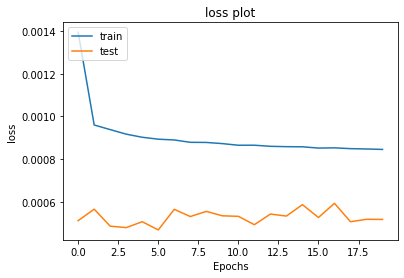

In [23]:
Lt=[]
Lv=[]
for i in res.history['loss']:
  Lt.append(i)
for i in res.history['val_loss']:
  Lv.append(i)
plt.plot(Lt)
plt.plot(Lv)
plt.title('loss plot')
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.legend(['train','test'],loc='upper left')
plt.show()

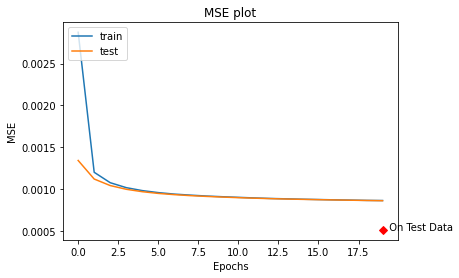

In [24]:
Lt=[]
Lv=[]
for i in res.history['mean_squared_error']:
  Lt.append(i)
for i in res.history['val_mean_squared_error']:
  Lv.append(i)
plt.plot(Lt)
plt.plot(Lv)
plt.title('MSE plot')
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.legend(['train','test'],loc='upper left')
plt.plot(epc-1,mse,"rD")
plt.annotate("  On Test Data",(epc-1,mse))
plt.show()

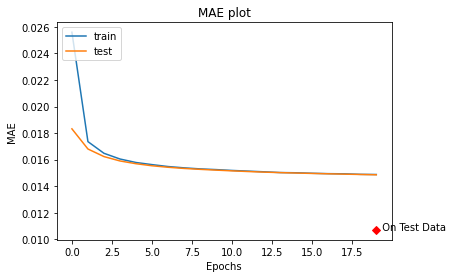

In [25]:
Lt=[]
Lv=[]
for i in res.history['mean_absolute_error']:
  Lt.append(i)
for i in res.history['val_mean_absolute_error']:
  Lv.append(i)
plt.plot(Lt)
plt.plot(Lv)
plt.title('MAE plot')
plt.ylabel('MAE')
plt.xlabel('Epochs')
plt.legend(['train','test'],loc='upper left')
plt.plot(epc-1,mae,"rD")
plt.annotate("  On Test Data",(epc-1,mae))
plt.show()

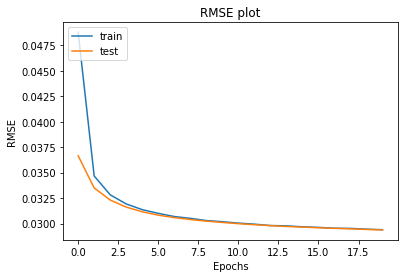

In [26]:
Lt=[]
Lv=[]
for i in res.history['root_mean_squared_error']:
  Lt.append(i)
for i in res.history['val_root_mean_squared_error']:
  Lv.append(i)
plt.plot(Lt)
plt.plot(Lv)
plt.title('RMSE plot')
plt.ylabel('RMSE')
plt.xlabel('Epochs')
plt.legend(['train','test'],loc='upper left')
plt.show()

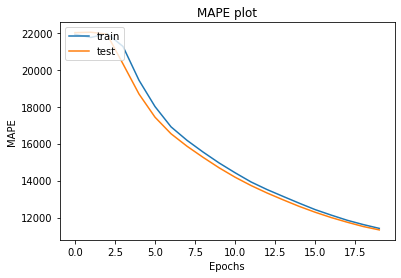

In [27]:
Lt=[]
Lv=[]
for i in res.history['mean_absolute_percentage_error']:
  Lt.append(i)
for i in res.history['val_mean_absolute_percentage_error']:
  Lv.append(i)
plt.plot(Lt)
plt.plot(Lv)
plt.title('MAPE plot')
plt.ylabel('MAPE')
plt.xlabel('Epochs')
plt.legend(['train','test'],loc='upper left')
plt.show()

#**Results**

In [28]:
# Inverse transporm to Undo Scaling
y_pred=sc_y.inverse_transform(y_pred)
y_test=sc_y.inverse_transform(y_test)

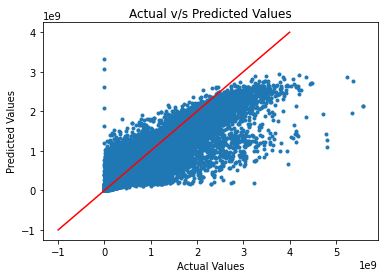

In [29]:
# Predicted v/s Actual Values Plot
plt.plot(y_test,y_pred,'.')
plt.title("Actual v/s Predicted Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")

a = np.linspace(-1e9,4e9, 100) 
b = a 
plt.plot(a,b,"red")
plt.show()

In [30]:
# R-squared Value
r=r2_score(y_test, y_pred)
print(r)

0.8679506040579563


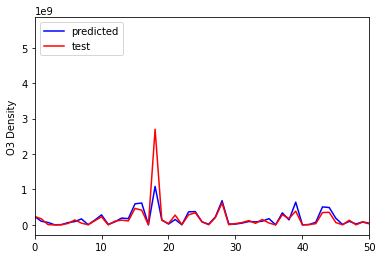

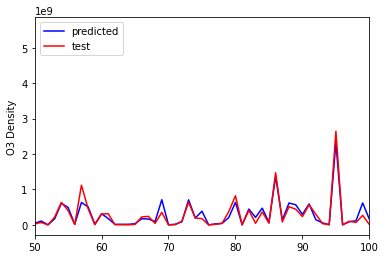

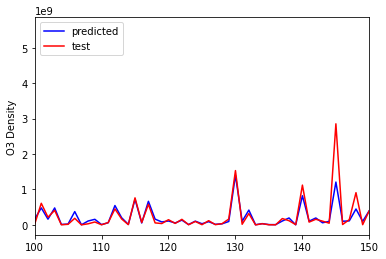

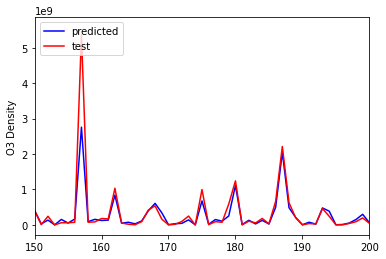

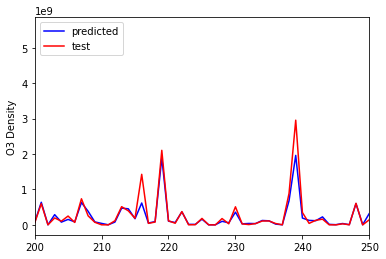

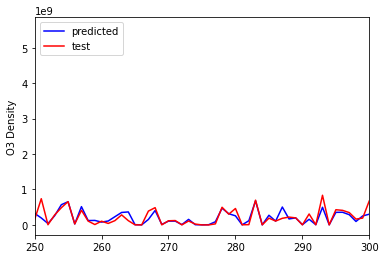

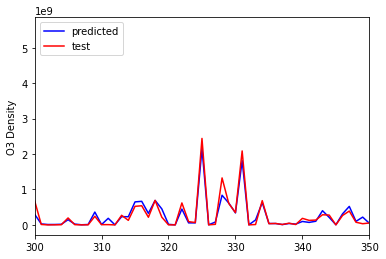

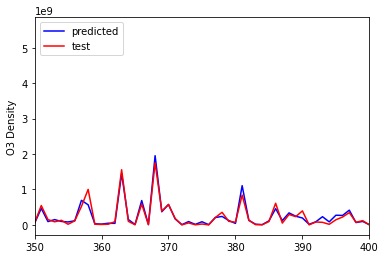

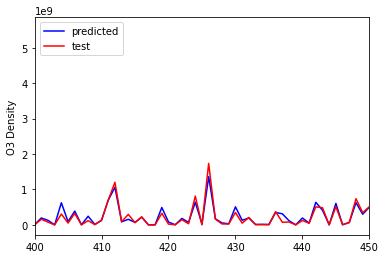

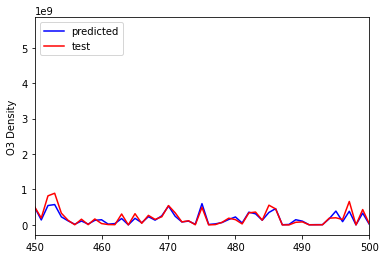

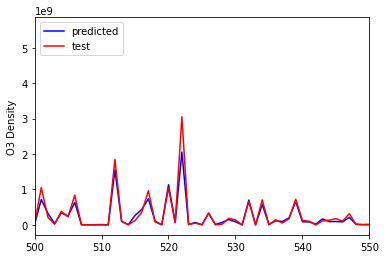

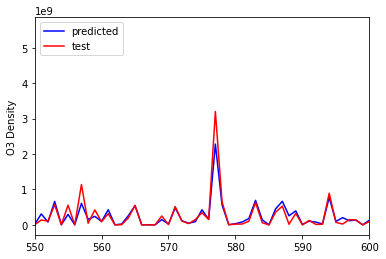

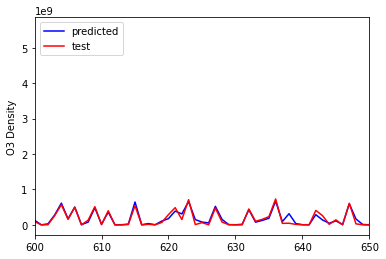

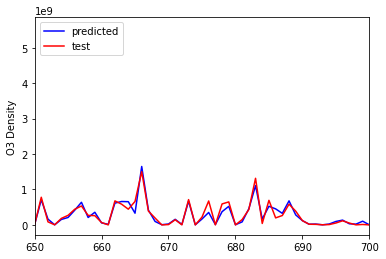

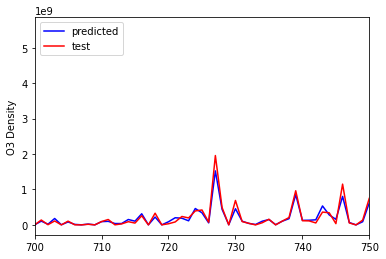

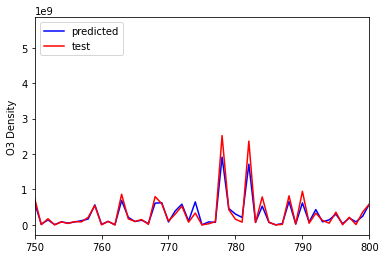

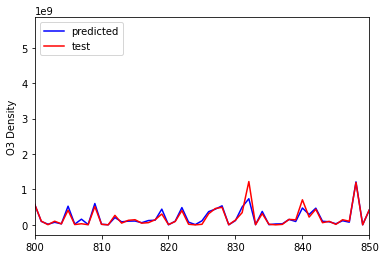

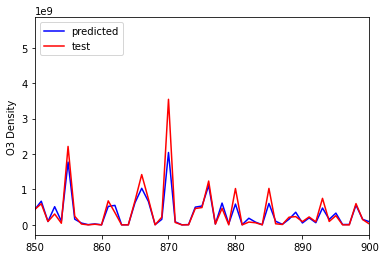

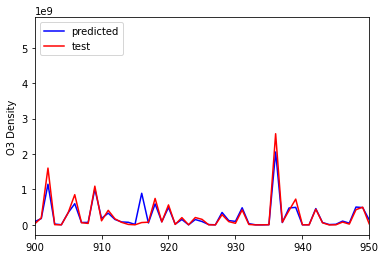

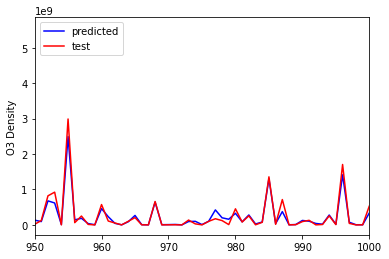

In [31]:
x = np.linspace(-20, 50, 100000)
for i in range(0,1000,50):
  plt.plot(y_pred, color='blue')
  plt.plot(y_test, color='red')
  plt.ylabel("O3 Density")
  plt.xlim([i,i+50])
  plt.legend(['predicted','test'],loc='upper left')
  plt.show()

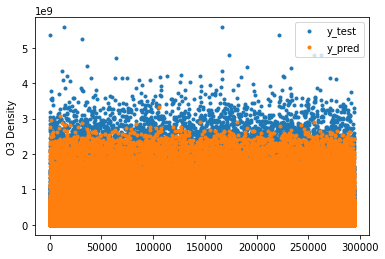

In [32]:
l=range(len(y_pred))

plt.plot(l,y_test,'.',label="y_test")
plt.plot(l,y_pred,'.',label="y_pred")
plt.ylabel("O3 Density")
plt.legend()
plt.show()

# **Testing Model On Oct 2003 Data**

In [33]:
X=pd.DataFrame(columns=x_col)
Y=pd.DataFrame(columns=y_col)
for i in x_col:
  X[i]=df3[i]

for i in y_col:
  Y[i]=df3[i]

X

,Date,event,solAp,solKp,solf10p7Daily,time,tpaltitude,tplatitude,tplongitude,tpSolarZen,ktemp,ae_index,dst_index,sym_h
0,26,1,10.0,2.3,243.4,998145,109.473373,12.064891,46.187244,126.984222,276.386414,56,-31,-30
1,26,1,10.0,2.3,243.4,998012,108.369583,12.062634,46.162155,127.008896,259.460693,56,-31,-30
2,26,1,10.0,2.3,243.4,997876,107.263870,12.060227,46.137043,127.033592,233.853317,56,-31,-30
3,26,1,10.0,2.3,243.4,997743,106.157074,12.057986,46.111958,127.058266,207.674591,56,-31,-30
4,26,1,10.0,2.3,243.4,997607,105.049255,12.055567,46.086845,127.082954,187.036041,56,-31,-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601267,31,98,116.0,4.3,248.9,87674469,74.702950,9.541140,25.907038,145.163940,207.508942,609,-69,-73
601268,31,98,116.0,4.3,248.9,87674600,73.563889,9.553928,25.884565,145.187637,206.174927,609,-69,-73
601269,31,98,116.0,4.3,248.9,87674738,72.423851,9.567107,25.862158,145.211319,209.336380,609,-69,-73
601270,31,98,116.0,4.3,248.9,87674867,71.282799,9.579803,25.839666,145.235016,211.722443,609,-69,-73


In [34]:
Y

,O3_density
0,2.553622e+06
1,3.085796e+06
2,3.753898e+06
3,3.461265e+06
4,5.661828e+06
...,...
601267,5.503687e+08
601268,9.593660e+08
601269,1.262374e+09
601270,1.519708e+09


In [35]:
X, _ , Y , __ = train_test_split(X, Y, test_size = 1e-5, random_state = 0)

In [36]:
# Scaling
X = sc_x.fit_transform(X)
Y = sc_y.fit_transform(Y)

In [37]:
Y_Pred=model.predict(X)

In [38]:
# Error Calculation in Testing Data
mse = np.mean(tf.keras.losses.mean_squared_error(Y, Y_Pred))
mae = np.mean(tf.keras.losses.mean_absolute_error(Y, Y_Pred))
r2 = r2_score(Y, Y_Pred)
print("Mean Squared Error: ",mse)
print("Mean Absolute Error: ",mae)
print("R2 Score: ",r2)

Mean Squared Error:  0.0018062961
Mean Absolute Error:  0.024855636
R2 Score:  0.7282548797540929


In [39]:
# Inverse transporm to Undo Scaling
Y=sc_y.inverse_transform(Y)
Y_Pred=sc_y.inverse_transform(Y_Pred)

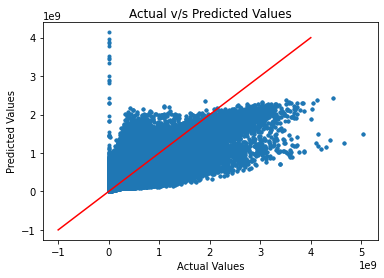

In [40]:
# Predicted v/s Actual Values Plot
plt.plot(Y,Y_Pred,'.')
plt.title("Actual v/s Predicted Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")

a = np.linspace(-1e9,4e9, 100)
b = a 
plt.plot(a,b,"red")
plt.show()

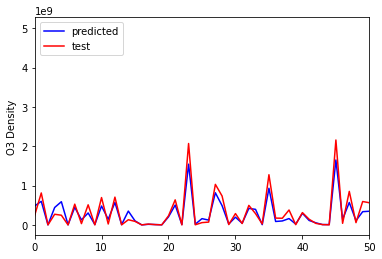

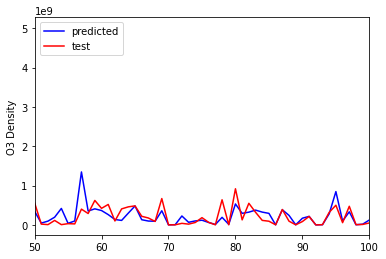

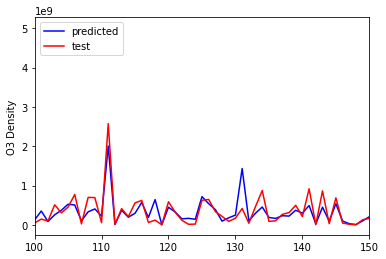

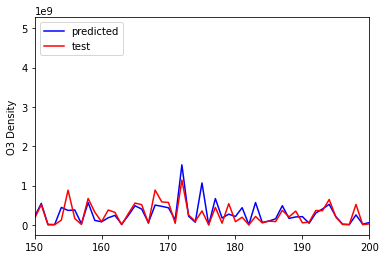

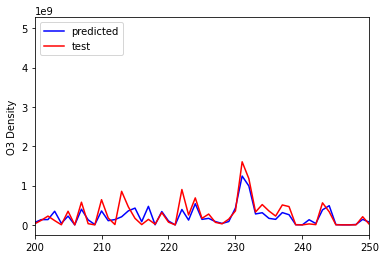

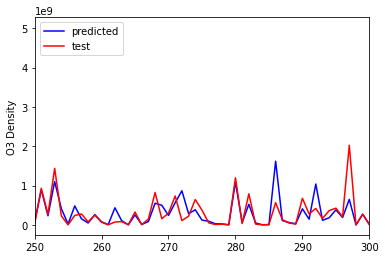

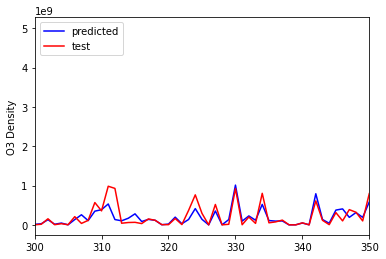

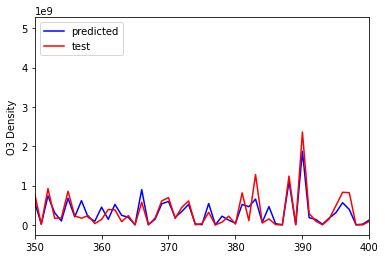

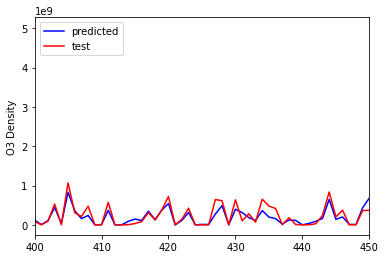

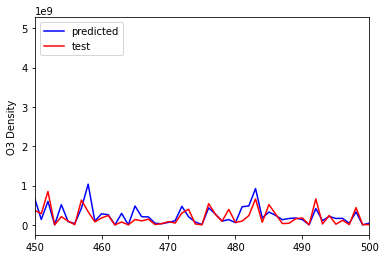

In [41]:
x = np.linspace(-20, 50, 100000)
for i in range(0,500,50):
  plt.plot(Y_Pred, color='blue')
  plt.plot(Y, color='red')
  plt.xlim([i,i+50])
  plt.ylabel("O3 Density")
  plt.legend(['predicted','test'],loc='upper left')
  plt.show()

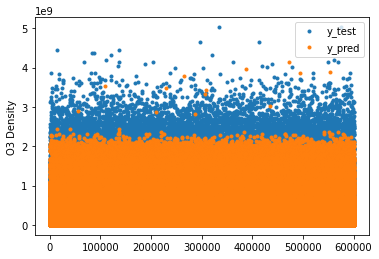

In [42]:
l=range(len(Y_Pred))

plt.plot(l,Y,'.',label="y_test")
plt.plot(l,Y_Pred,'.',label="y_pred")
plt.ylabel("O3 Density")
plt.legend()
plt.show()